In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import random
from scipy.stats import gaussian_kde as GKDE
from scipy.stats import multivariate_normal
from scipy.stats import norm
import scipy.integrate as integrate
import seaborn as sns

import src.weightedEDFs as wEDFs
import src.binning as binning

In [2]:
# set plotting parameters
plot_directory = './plots'

if not os.path.exists(plot_directory):
    os.makedirs(plot_directory)

mpl.rcParams['lines.linewidth'] = 4
plt.rc('font', size=14)
plt.rc('axes', titlesize=16)
plt.rc('axes', labelsize=16)
mpl.rcParams['lines.markersize'] = 5
mpl.rcParams['figure.figsize'] = (5.5, 4)
mpl.rcParams['lines.linewidth'] = 2.5

CB_color_cycle = ('#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00')
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=CB_color_cycle) 

In [3]:
random.seed(20)

## Problem setup

This problem corresponds to heat equation illustrative example problem described in Section 2.4 of the paper.

In [4]:
# average value of parameters
l = 2.
kappa = 1.

In [5]:
t = .01

In [6]:
def u_k(k, x, t, l, kappa):
    
    return (2 * l**2 * (-1)**(k+1) / (np.pi * k)
            * np.sin(k * np.pi * x / l)
            * np.exp(-kappa * (k * np.pi)**2 * t) / l**2)

def u(N, x, t, l, kappa):
    
    u_N = 0 * x
    for k in range(1, N):
        u_N += u_k(k, x, t, l, kappa)

    return u_N

In [7]:
N = 100 # solution truncation

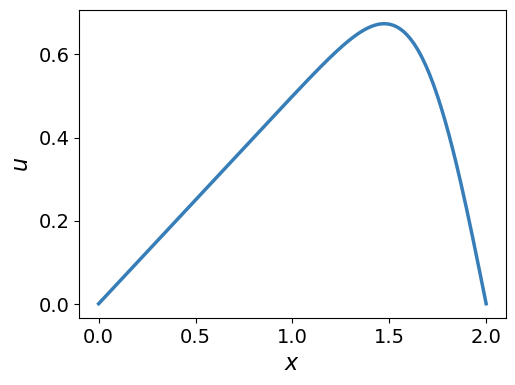

In [8]:
# plotting a sample solution to the equation
x = np.linspace(0, l, 2*N)
u_N = u(N, x, t, l, kappa)

plt.plot(x, u_N);

plt.xlabel('$x$');
plt.ylabel('$u$');

## DCI problem

Here, we set up the DCI problem for the illustrative example, by which we mean we set up the initial, predicted, and observed distributions and generate samples.

In [9]:
sensor_loc = 1.2

In [10]:
# initial distribution
n_init_samples = 2000

delta_l = 0.1
delta_kappa = 0.5

init_samples = np.random.uniform(0, 1, (n_init_samples,2))
init_samples[:,0] = init_samples[:,0] * delta_l + l - delta_l / 2
init_samples[:,1] = init_samples[:,1] * delta_kappa + kappa - delta_kappa / 2

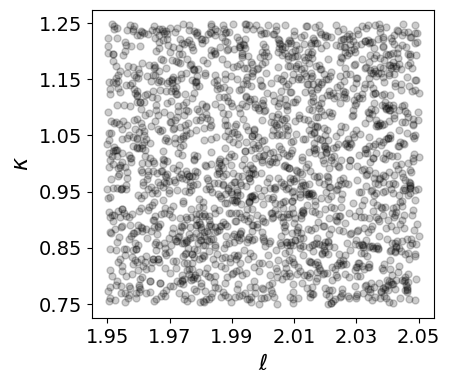

In [11]:
# plotting initial samples in the parameter space
X = np.linspace(l - delta_l / 2, delta_l + l - delta_l / 2, 100)
Y = np.linspace(kappa - delta_kappa / 2, delta_kappa + kappa - delta_kappa / 2, 100)

XX, YY = np.meshgrid(X, Y)

plt.scatter(init_samples[:,0], init_samples[:,1], alpha=0.2, color='k')

ax = plt.gca()
ax.set_aspect(0.18)
plt.xlabel(r'$\ell$');
plt.ylabel(r'$\kappa$');
plt.xticks(ticks=np.linspace(np.min(XX), np.max(XX), 6),
           labels=["{:.2f}".format(x) for x in np.linspace(np.min(XX), np.max(XX), 6)]);
plt.yticks(ticks=np.linspace(np.min(YY), np.max(YY), 6),
           labels=["{:.2f}".format(x) for x in np.linspace(np.min(YY), np.max(YY), 6)]);

In [12]:
# plotting contours of the QoI map in the parameter space
ZZ = np.zeros(np.shape(XX))

for count, x in enumerate(X):
    ZZ[count,:] = u(N, sensor_loc, t, XX[count,:], YY[count,:])

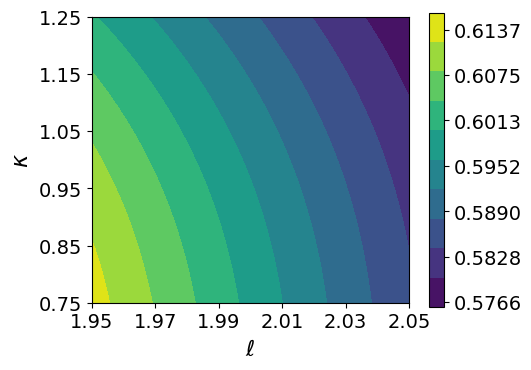

In [13]:
plt.contourf(XX, YY, ZZ, levels=9);
ax = plt.gca()
ax.set_aspect(0.18)

plt.ylabel(r'$\kappa$');
plt.xlabel(r'$\ell$');
plt.xticks(ticks=np.linspace(np.min(XX), np.max(XX), 6),
           labels=["{:.2f}".format(x) for x in np.linspace(np.min(XX), np.max(XX), 6)])
plt.yticks(ticks=np.linspace(np.min(YY), np.max(YY), 6),
           labels=["{:.2f}".format(x) for x in np.linspace(np.min(YY), np.max(YY), 6)])

cbar = plt.colorbar()
cbar.set_ticks(np.linspace(np.min(ZZ), np.max(ZZ), 7))
cbar.set_ticklabels(["{:.4f}".format(x) for x in np.linspace(np.min(ZZ), np.max(ZZ), 7)])

plt.tight_layout()
plt.savefig(f'{plot_directory}/contours.png', bbox_inches='tight')

In [14]:
# push initial samples through QoI map to generate predicted samples
pred_samples = np.zeros((n_init_samples, 1))
pred_samples[:, 0] = u(N, sensor_loc, t, init_samples[:,0], init_samples[:,1])

In [15]:
# generate observed samples from a distribution
obs_dist = norm(0.595, 3e-3)

n_obs_samples = 10000
obs_samples = obs_dist.rvs(n_obs_samples)

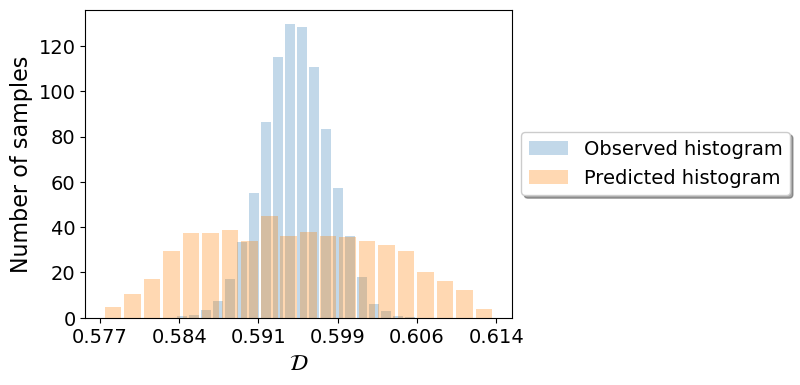

In [16]:
xx = np.linspace(np.min(pred_samples), np.max(pred_samples), 1000)

plt.hist(obs_samples, bins=20, alpha=0.3, density=True, label='Observed histogram', rwidth=0.85);
plt.hist(pred_samples, bins=20, alpha=0.3, density=True, label='Predicted histogram', rwidth=0.85);

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True);
plt.xlabel(r'$\mathcal{D}$');
plt.xticks(ticks=np.linspace(np.min(ZZ), np.max(ZZ), 6),
           labels=["{:.3f}".format(x) for x in np.linspace(np.min(ZZ), np.max(ZZ), 6)]);
plt.ylabel('Number of samples');

## Density-based solution

The density-based solution using KDEs for the illustrative example, described in Section 2.4 of the paper, is computed below.

In [17]:
# for the density solution we will do rejection sampling
def rejection_sampling(r):

    unifs = np.random.uniform(0,1,len(r))
    M = np.max(r)

    return (unifs < (r / M))

In [18]:
pred_KDE = GKDE(pred_samples[:,0])
obs_KDE = GKDE(obs_samples)

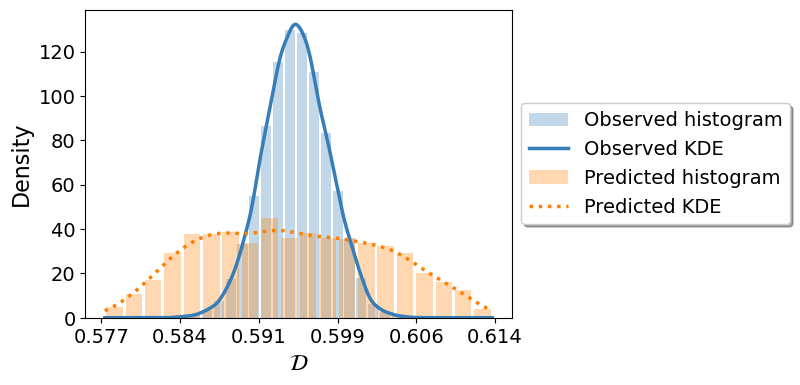

In [19]:
xx = np.linspace(np.min(pred_samples), np.max(pred_samples), 1000)

plt.hist(obs_samples, bins=20, alpha=0.3, density=True, label='Observed histogram', rwidth=0.85, color=CB_color_cycle[0]);
plt.plot(xx, obs_KDE(xx), color=CB_color_cycle[0], label='Observed KDE');

plt.hist(pred_samples, bins=20, alpha=0.3, density=True, label='Predicted histogram', rwidth=0.85, color=CB_color_cycle[1]);
plt.plot(xx, pred_KDE(xx), color=CB_color_cycle[1], label='Predicted KDE', ls=':');

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True);
plt.xlabel(r'$\mathcal{D}$');
plt.xticks(ticks=np.linspace(np.min(ZZ), np.max(ZZ), 6),
           labels=["{:.3f}".format(x) for x in np.linspace(np.min(ZZ), np.max(ZZ), 6)]);
plt.ylabel('Density');

In [20]:
# an example of a bad diagnostic, where the density-based solution fails
bad_obs_dist = norm(0.613, 7e-3)

n_obs_samples = 10000
bad_obs_samples = bad_obs_dist.rvs(n_obs_samples)

bad_obs_KDE = GKDE(bad_obs_samples)

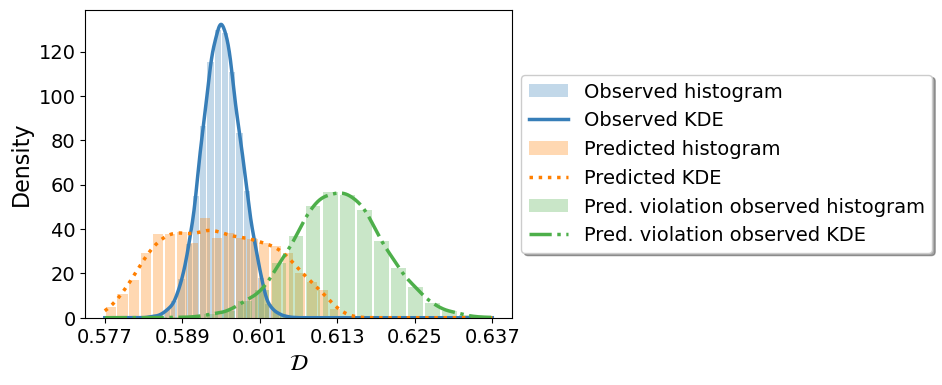

In [32]:
xx = np.linspace(np.min(pred_samples), np.max(bad_obs_samples), 1000)

plt.hist(obs_samples, bins=20, alpha=0.3, density=True, label='Observed histogram', rwidth=0.85, color=CB_color_cycle[0]);
plt.plot(xx, obs_KDE(xx), color=CB_color_cycle[0], label='Observed KDE');

plt.hist(pred_samples, bins=20, alpha=0.3, density=True, label='Predicted histogram', rwidth=0.85, color=CB_color_cycle[1]);
plt.plot(xx, pred_KDE(xx), color=CB_color_cycle[1], label='Predicted KDE', ls=':');

plt.hist(bad_obs_samples, bins=20, alpha=0.3, density=True, label='Pred. violation observed histogram',
         rwidth=0.85, color=CB_color_cycle[2]);
plt.plot(xx, bad_obs_KDE(xx), color=CB_color_cycle[2], label='Pred. violation observed KDE', ls='-.');

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True);
plt.xlabel(r'$\mathcal{D}$');
plt.xticks(ticks=np.linspace(np.min(pred_samples), np.max(bad_obs_samples), 6),
           labels=["{:.3f}".format(x) for x in np.linspace(np.min(pred_samples), np.max(bad_obs_samples), 6)]);
plt.ylabel('Density');

plt.savefig(f'{plot_directory}/heat_eq_dists.png', bbox_inches='tight');

In [33]:
# compute the density-based solution weights (radon-nikodym weights) on the initial samples
r = obs_KDE(pred_samples.T) / pred_KDE(pred_samples.T)
rn_w = r / n_init_samples
print(f'E(r) = {np.mean(r)}') # computes the diagnostic for the density solution

E(r) = 1.0055344181500823


In [34]:
r_bad = bad_obs_KDE(pred_samples.T) / pred_KDE(pred_samples.T)
print(f'E(r) = {np.mean(r_bad)}')

E(r) = 0.5197296671036711


In [35]:
# once we have the radon-nikodym weights, we use rejection sampling to find the solution and its push-forward
update_inds = rejection_sampling(r)
update_samples = init_samples[update_inds]

pf_samples = pred_samples[update_inds]
pf_KDE = GKDE(pf_samples.T)

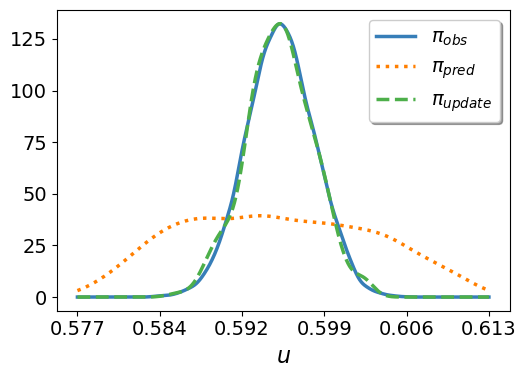

In [36]:
xx = np.linspace(np.min(pred_samples[:,0]), np.max(pred_samples[:,0]), 1000)

plt.plot(xx, obs_KDE(xx), label=r'$\pi_{obs}$', ls='-');
plt.plot(xx, pred_KDE(xx), label=r'$\pi_{pred}$', ls=':');
plt.plot(xx, pf_KDE(xx), label=r'$\pi_{update}$', ls='--');

plt.xticks(ticks=np.linspace(np.min(pred_samples), np.max(pred_samples), 6),
           labels=["{:.3f}".format(x) for x in np.linspace(np.min(pred_samples), np.max(pred_samples), 6)]);
plt.xlabel(r'$u$');
plt.legend(shadow=True);

plt.tight_layout()
plt.savefig(f'{plot_directory}/dens_results.png', bbox_inches='tight')

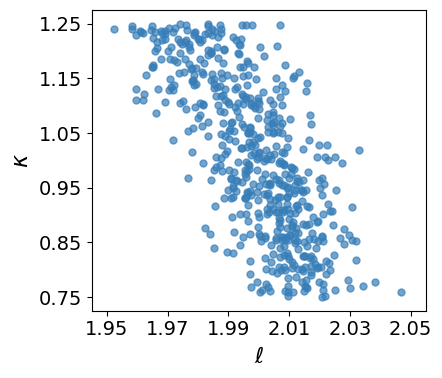

In [37]:
plt.scatter(init_samples[update_inds,0], init_samples[update_inds,1], alpha=0.7)

ax = plt.gca()
ax.set_aspect(0.18)

plt.xlim(1.945, 2.055);
plt.ylim(0.725, 1.275);
plt.xlabel(r'$\ell$');
plt.ylabel(r'$\kappa$');
plt.xticks(ticks=np.linspace(np.min(XX), np.max(XX), 6),
           labels=["{:.2f}".format(x) for x in np.linspace(np.min(XX), np.max(XX), 6)]);
plt.yticks(ticks=np.linspace(np.min(YY), np.max(YY), 6),
           labels=["{:.2f}".format(x) for x in np.linspace(np.min(YY), np.max(YY), 6)]);

plt.tight_layout();
plt.savefig(f'{plot_directory}/rejection.png', bbox_inches='tight');

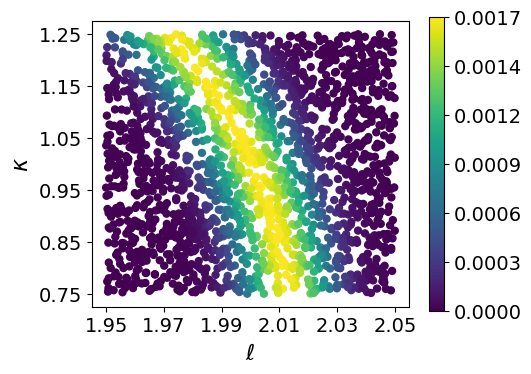

In [38]:
ax = plt.gca()
ax.set_aspect(0.18)

plt.scatter(init_samples[:,0], init_samples[:,1], c=r/n_init_samples);

plt.xlim(1.945, 2.055);
plt.ylim(0.725, 1.275);
plt.xlabel(r'$\ell$');
plt.ylabel(r'$\kappa$');
plt.xticks(ticks=np.linspace(np.min(XX), np.max(XX), 6),
           labels=["{:.2f}".format(x) for x in np.linspace(np.min(XX), np.max(XX), 6)]);
plt.yticks(ticks=np.linspace(np.min(YY), np.max(YY), 6),
           labels=["{:.2f}".format(x) for x in np.linspace(np.min(YY), np.max(YY), 6)]);

cbar = plt.colorbar();
cbar.set_ticks(np.linspace(np.min(r/n_init_samples), np.max(r/n_init_samples), 7));
cbar.set_ticklabels(["{:.4f}".format(x) for x in np.linspace(np.min(r/n_init_samples),
                                                             np.max(r/n_init_samples), 7)]);

plt.tight_layout()
plt.savefig(f'{plot_directory}/rn_weights.png', bbox_inches='tight')

## Naive optimization solution

The naive optimization solution for the DCI problem, corresponding to Section 3.2 from the paper, is found below.

In [39]:
H = wEDFs.compute_H(np.reshape(pred_samples, (len(pred_samples),1)))
b = wEDFs.compute_b(np.reshape(pred_samples, (len(pred_samples),1)),
                    sample_set_2=np.reshape(obs_samples, (len(obs_samples),1)))
w = wEDFs.compute_optimal_w(H, b)

     pcost       dcost       gap    pres   dres
 0: -2.1777e-01 -2.0003e+03  2e+03  2e-16  9e+01
 1: -2.1777e-01 -2.0251e+01  2e+01  9e-15  9e-01
 2: -2.1782e-01 -4.5104e-01  2e-01  9e-15  1e-02
 3: -2.2082e-01 -2.4901e-01  3e-02  8e-15  1e-03
 4: -2.2862e-01 -2.4076e-01  1e-02  1e-14  2e-18
 5: -2.2952e-01 -2.3135e-01  2e-03  1e-14  2e-18
 6: -2.2986e-01 -2.3020e-01  3e-04  1e-14  2e-18
 7: -2.2991e-01 -2.2996e-01  5e-05  1e-14  2e-18
 8: -2.2992e-01 -2.2993e-01  1e-05  1e-14  2e-18
 9: -2.2992e-01 -2.2993e-01  2e-06  1e-14  2e-18
10: -2.2992e-01 -2.2992e-01  4e-07  1e-14  2e-18
11: -2.2992e-01 -2.2992e-01  8e-08  1e-14  2e-18
Optimal solution found.


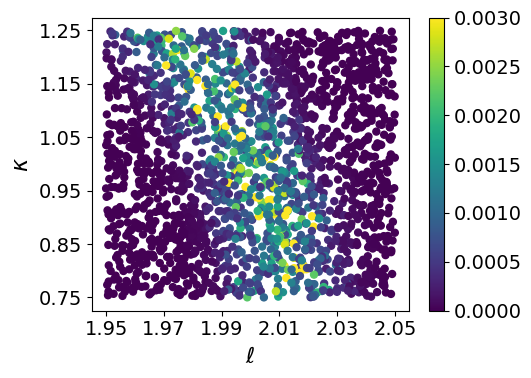

In [40]:
vmin = 0
vmax = 0.003
plt.scatter(init_samples[:,0], init_samples[:,1], c=w/n_init_samples, cmap='viridis', vmin=vmin, vmax=vmax)

plt.xlabel(r'$\ell$');
plt.ylabel(r'$\kappa$');
plt.xticks(ticks=np.linspace(np.min(XX), np.max(XX), 6),
           labels=["{:.2f}".format(x) for x in np.linspace(np.min(XX), np.max(XX), 6)]);
plt.yticks(ticks=np.linspace(np.min(YY), np.max(YY), 6),
           labels=["{:.2f}".format(x) for x in np.linspace(np.min(YY), np.max(YY), 6)]);

cbar = plt.colorbar();
cbar.set_ticks(np.linspace(vmin, vmax, 7));
cbar.set_ticklabels(["{:.4f}".format(x) for x in np.linspace(vmin, vmax, 7)]);

plt.tight_layout();
plt.savefig(f'{plot_directory}/naive_weights.png', bbox_inches='tight');

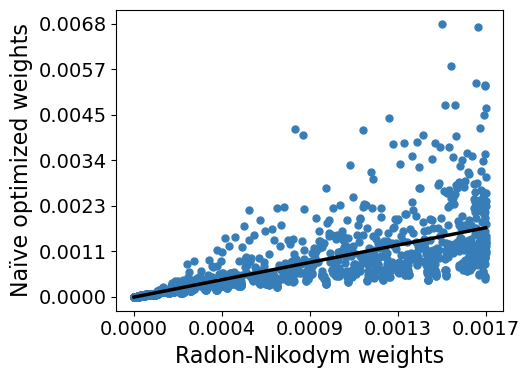

In [41]:
plt.scatter(rn_w, w/n_init_samples);
plt.plot(np.linspace(0, np.max(rn_w), 1000),
         np.linspace(0, np.max(rn_w), 1000), color='k');

plt.xticks(ticks=np.linspace(np.min(rn_w), np.max(rn_w), 5),
           labels=["{:.4f}".format(x) for x in np.linspace(np.min(rn_w), np.max(rn_w), 5)]);
plt.yticks(ticks=np.linspace(np.min(w/n_init_samples), np.max(w/n_init_samples), 7),
           labels=["{:.4f}".format(x) for x in np.linspace(np.min(w/n_init_samples), np.max(w/n_init_samples), 7)]);
plt.xlabel('Radon-Nikodym weights');
plt.ylabel('Naïve optimized weights');

plt.tight_layout()
plt.savefig(f'{plot_directory}/rn_vs_naive.png')

## Binning methods

Next, we compute the solution using the binning method described in Section 3.3 of the paper.

In [42]:
p = 35

### Regular partitioning

We demonstrate the method computing the bins using regular partitioning first.

In [43]:
rpartitioned_w, bins, centers, w_center = binning.computePartitionedWeights_regulargrid_IID(init_samples,
                                                                        pred_samples,
                                                                        sample_set_2=np.reshape(obs_samples, (len(obs_samples),1)),
                                                                        n_bins=p)

     pcost       dcost       gap    pres   dres
 0: -2.0698e-01 -3.5262e+01  4e+01  3e-16  1e+01
 1: -2.0704e-01 -6.1203e-01  4e-01  1e-15  1e-01
 2: -2.1124e-01 -2.6055e-01  5e-02  1e-15  2e-02
 3: -2.2665e-01 -2.5321e-01  3e-02  2e-15  2e-17
 4: -2.2820e-01 -2.3198e-01  4e-03  2e-15  2e-17
 5: -2.2904e-01 -2.2993e-01  9e-04  2e-15  2e-17
 6: -2.2918e-01 -2.2932e-01  1e-04  3e-15  2e-17
 7: -2.2921e-01 -2.2923e-01  2e-05  2e-15  1e-17
 8: -2.2921e-01 -2.2922e-01  3e-06  2e-15  2e-17
 9: -2.2921e-01 -2.2921e-01  5e-07  2e-15  2e-17
10: -2.2921e-01 -2.2921e-01  7e-08  3e-15  2e-17
Optimal solution found.


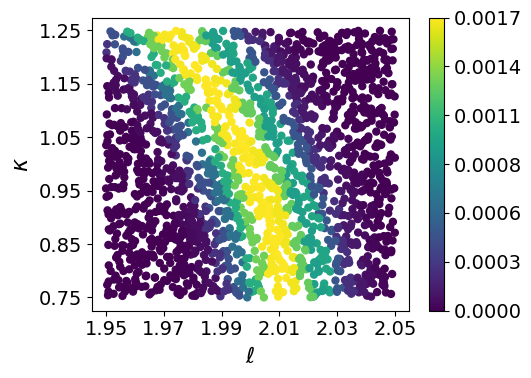

In [44]:
plt.scatter(init_samples[:,0], init_samples[:,1], c=rpartitioned_w)

plt.xlabel(r'$\ell$');
plt.ylabel(r'$\kappa$');
plt.xticks(ticks=np.linspace(np.min(XX), np.max(XX), 6),
           labels=["{:.2f}".format(x) for x in np.linspace(np.min(XX), np.max(XX), 6)]);
plt.yticks(ticks=np.linspace(np.min(YY), np.max(YY), 6),
           labels=["{:.2f}".format(x) for x in np.linspace(np.min(YY), np.max(YY), 6)]);

cbar = plt.colorbar();
cbar.set_ticks(np.linspace(np.min(rpartitioned_w), np.max(rpartitioned_w), 7));
cbar.set_ticklabels(["{:.4f}".format(x) for x in np.linspace(np.min(rpartitioned_w),
                                                             np.max(rpartitioned_w), 7)]);

plt.tight_layout()
plt.savefig(f'{plot_directory}/regpart_weights.png', bbox_inches='tight')

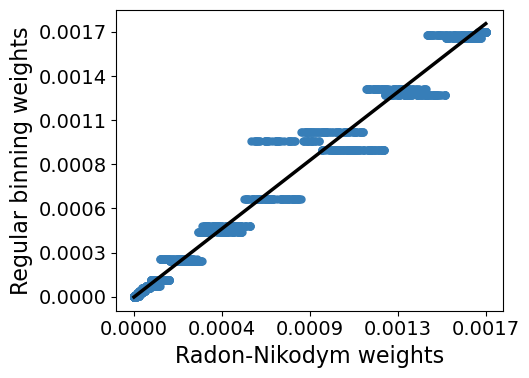

In [45]:
plt.scatter(rn_w, rpartitioned_w)
plt.plot(np.linspace(0, np.max(rn_w), 1000),
         np.linspace(0, np.max(rn_w), 1000), color='k');

plt.xticks(ticks=np.linspace(np.min(rn_w), np.max(rn_w), 5),
           labels=["{:.4f}".format(x) for x in np.linspace(np.min(rn_w), np.max(rn_w), 5)]);
plt.yticks(ticks=np.linspace(np.min(rpartitioned_w), np.max(rpartitioned_w), 7),
           labels=["{:.4f}".format(x) for x in np.linspace(np.min(rpartitioned_w), np.max(rpartitioned_w), 7)]);
plt.xlabel('Radon-Nikodym weights');
plt.ylabel('Regular binning weights');

plt.tight_layout()
plt.savefig(f'{plot_directory}/rn_vs_regpart.png', bbox_inches='tight')

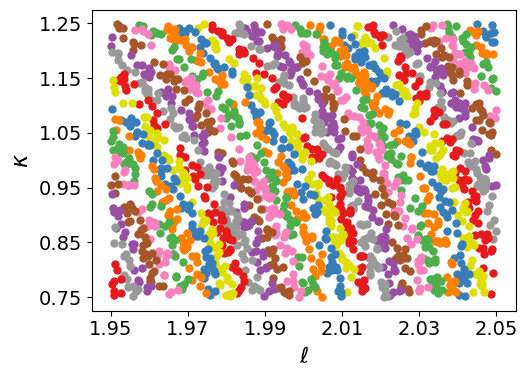

In [46]:
for i in range(p):
    plt.scatter(init_samples[(bins==i),0],init_samples[(bins==i),1])

plt.xlabel(r'$\ell$');
plt.ylabel(r'$\kappa$');
plt.xticks(ticks=np.linspace(np.min(XX), np.max(XX), 6),
           labels=["{:.2f}".format(x) for x in np.linspace(np.min(XX), np.max(XX), 6)]);
plt.yticks(ticks=np.linspace(np.min(YY), np.max(YY), 6),
           labels=["{:.2f}".format(x) for x in np.linspace(np.min(YY), np.max(YY), 6)]);

plt.tight_layout();
plt.savefig(f'{plot_directory}/regpart_cells.png', bbox_inches='tight')

### K-means partitioning

Next, we demonstrate the method using K-means partitioning.

In [47]:
kpartitioned_w, clusters, centers, w_center = binning.computePartitionedWeights_kMeans_IID(init_samples,
                                                                        pred_samples,
                                                                        sample_set_2=np.reshape(obs_samples, (len(obs_samples),1)),
                                                                        n_clusters=p)

     pcost       dcost       gap    pres   dres
 0: -2.0681e-01 -3.5253e+01  4e+01  1e-16  1e+01
 1: -2.0686e-01 -6.0263e-01  4e-01  1e-15  1e-01
 2: -2.1030e-01 -2.5174e-01  4e-02  1e-15  1e-02
 3: -2.2243e-01 -2.4189e-01  2e-02  2e-15  1e-17
 4: -2.2374e-01 -2.2660e-01  3e-03  2e-15  2e-17
 5: -2.2432e-01 -2.2482e-01  5e-04  2e-15  1e-17
 6: -2.2440e-01 -2.2448e-01  8e-05  2e-15  1e-17
 7: -2.2442e-01 -2.2443e-01  1e-05  3e-15  1e-17
 8: -2.2442e-01 -2.2442e-01  2e-06  1e-15  2e-17
 9: -2.2442e-01 -2.2442e-01  3e-07  1e-15  3e-17
10: -2.2442e-01 -2.2442e-01  4e-08  1e-15  2e-17
Optimal solution found.


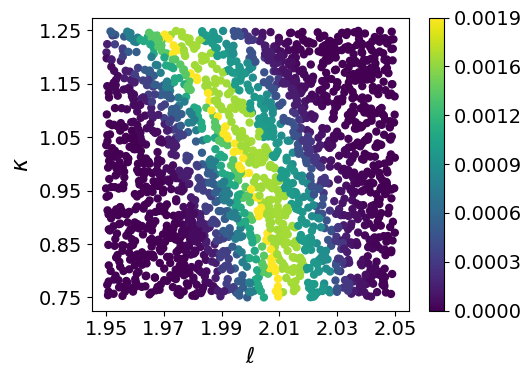

In [48]:
plt.scatter(init_samples[:,0], init_samples[:,1], c=kpartitioned_w)

plt.xlabel(r'$\ell$')
plt.ylabel(r'$\kappa$')
plt.xticks(ticks=np.linspace(np.min(XX), np.max(XX), 6),
           labels=["{:.2f}".format(x) for x in np.linspace(np.min(XX), np.max(XX), 6)])
plt.yticks(ticks=np.linspace(np.min(YY), np.max(YY), 6),
           labels=["{:.2f}".format(x) for x in np.linspace(np.min(YY), np.max(YY), 6)])

cbar = plt.colorbar()
cbar.set_ticks(np.linspace(np.min(kpartitioned_w), np.max(kpartitioned_w), 7))
cbar.set_ticklabels(["{:.4f}".format(x) for x in np.linspace(np.min(kpartitioned_w),
                                                             np.max(kpartitioned_w), 7)])

plt.tight_layout()
plt.savefig(f'{plot_directory}/kmeans_part_weights.png', bbox_inches='tight')

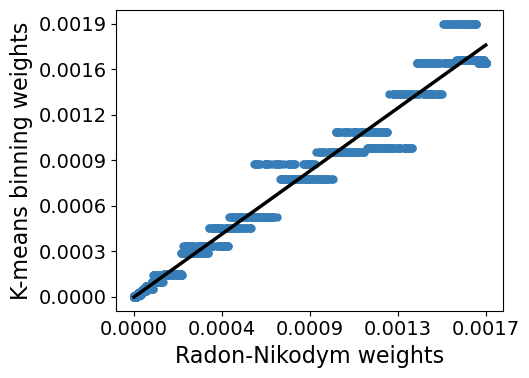

In [49]:
plt.scatter(rn_w, kpartitioned_w);
plt.plot(np.linspace(0, np.max(rn_w), 1000),
         np.linspace(0, np.max(rn_w), 1000), color='k');

plt.xticks(ticks=np.linspace(np.min(rn_w), np.max(rn_w), 5),
           labels=["{:.4f}".format(x) for x in np.linspace(np.min(rn_w), np.max(rn_w), 5)]);
plt.yticks(ticks=np.linspace(np.min(kpartitioned_w), np.max(kpartitioned_w), 7),
           labels=["{:.4f}".format(x) for x in np.linspace(np.min(kpartitioned_w), np.max(kpartitioned_w), 7)]);
plt.xlabel('Radon-Nikodym weights');
plt.ylabel('K-means binning weights');

plt.tight_layout();
plt.savefig(f'{plot_directory}/rn_vs_kmeans_part.png');

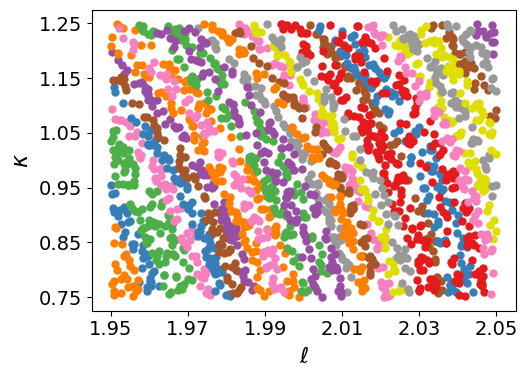

In [50]:
for i in range(p):
    plt.scatter(init_samples[(clusters==i),0], init_samples[(clusters==i),1]);

plt.xlabel(r'$\ell$');
plt.ylabel(r'$\kappa$');

plt.xticks(ticks=np.linspace(np.min(XX), np.max(XX), 6),
           labels=["{:.2f}".format(x) for x in np.linspace(np.min(XX), np.max(XX), 6)]);
plt.yticks(ticks=np.linspace(np.min(YY), np.max(YY), 6),
           labels=["{:.2f}".format(x) for x in np.linspace(np.min(YY), np.max(YY), 6)]);

plt.tight_layout();
plt.savefig(f'{plot_directory}/kmeans_part_cells.png', bbox_inches='tight');

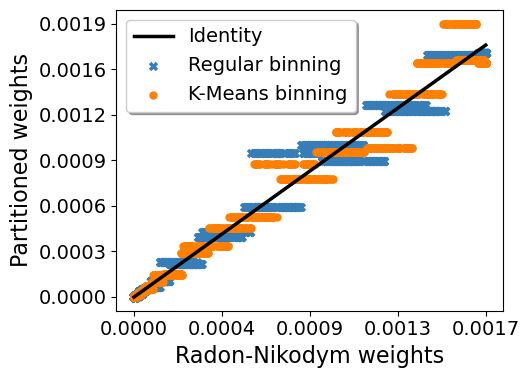

In [51]:
plt.plot(np.linspace(0, np.max(rn_w), 1000),
         np.linspace(0, np.max(rn_w), 1000), color='k', label='Identity');
plt.scatter(rn_w, rpartitioned_w, label='Regular binning', marker='x');

plt.xlabel('Radon-Nikodym weights');
plt.ylabel('Partitioned weights');
plt.scatter(rn_w, kpartitioned_w, label='K-Means binning');
plt.xticks(ticks=np.linspace(np.min(rn_w), np.max(rn_w), 5),
           labels=["{:.4f}".format(x) for x in np.linspace(np.min(rn_w), np.max(rn_w), 5)]);
plt.yticks(ticks=np.linspace(np.min(kpartitioned_w), np.max(kpartitioned_w), 7),
           labels=["{:.4f}".format(x) for x in np.linspace(np.min(kpartitioned_w), np.max(kpartitioned_w), 7)]);
plt.legend(shadow=True);

plt.tight_layout();
plt.savefig(f'{plot_directory}/regpart_vs_kmeans.png')

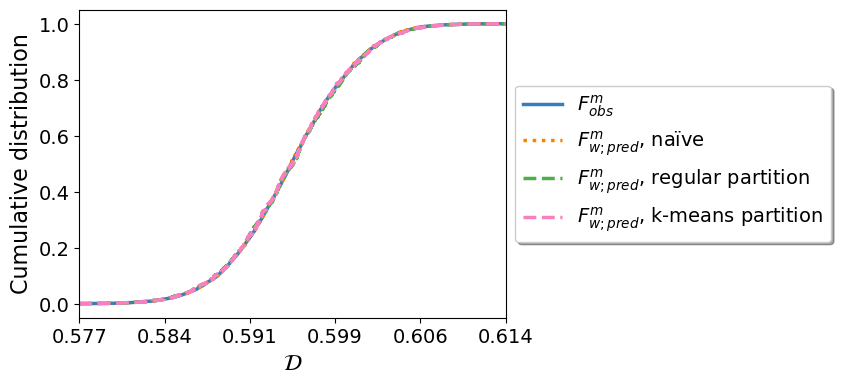

In [52]:
isort = np.argsort(pred_samples[:n_init_samples,0])
isort_obs = np.argsort(obs_samples)

plt.plot(np.append(np.min(pred_samples[:,0]), np.append(obs_samples[isort_obs], np.max(pred_samples[:,0]))),
         np.append(0, np.append(np.cumsum([1/n_obs_samples]*n_obs_samples), 1)), label=r'$F^m_{obs}$');
plt.step(pred_samples[isort], np.cumsum(w[isort]/n_init_samples),
         label=r'$F^m_{w;pred}$, naïve', ls='dotted');
plt.step(pred_samples[isort], np.cumsum(rpartitioned_w[isort]),
         label=r'$F^m_{w;pred}$, regular partition', ls='--');
plt.step(pred_samples[isort], np.cumsum(kpartitioned_w[isort]),
         label=r'$F^m_{w;pred}$, k-means partition', ls='--');

plt.xlim(0.584, 0.606)
plt.xticks(ticks=np.linspace(0.584, 0.606, 6),
           labels=["{:.3f}".format(x) for x in np.linspace(np.min(ZZ), np.max(ZZ), 6)]);
plt.xlabel(r'$\mathcal{D}$');
plt.ylabel('Cumulative distribution');
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True);

plt.savefig(f'{plot_directory}/cdf_compare.png', bbox_inches='tight');

## Run for smaller initial sample size to plot EDF steps

For some of the plots in the paper, it is useful to run the method with a smaller number of initial samples, so that we can see the steps in the empirical distribution function. The following repeats the problem described above with the number of initial samples reduced.

In [53]:
n_init_samples_small = 200

H = wEDFs.compute_H(pred_samples[:n_init_samples_small,:])
b = wEDFs.compute_b(pred_samples[:n_init_samples_small,:], targ_CDF=obs_dist.cdf)
w = wEDFs.compute_optimal_w(H, b)

p = 10

kpartitioned_w, clusters, centers, w_center = binning.computePartitionedWeights_kMeans_IID(init_samples[:n_init_samples_small,:],
                                                                        pred_samples[:n_init_samples_small,:],
                                                                        sample_set_2=np.reshape(obs_samples, (len(obs_samples),1)),
                                                                        n_clusters=p)

rpartitioned_w, bins, centers, w_center = binning.computePartitionedWeights_regulargrid_IID(init_samples[:n_init_samples_small,:],
                                                                        pred_samples[:n_init_samples_small,:],
                                                                        sample_set_2=np.reshape(obs_samples, (len(obs_samples),1)),
                                                                        n_bins=p)

     pcost       dcost       gap    pres   dres
 0: -2.2616e-01 -2.0026e+02  2e+02  1e-15  3e+01
 1: -2.2616e-01 -2.2643e+00  2e+00  3e-15  3e-01
 2: -2.2667e-01 -2.8362e-01  6e-02  3e-15  8e-03
 3: -2.3691e-01 -2.4864e-01  1e-02  3e-15  5e-18
 4: -2.3954e-01 -2.4203e-01  2e-03  4e-15  5e-18
 5: -2.3999e-01 -2.4041e-01  4e-04  4e-15  4e-18
 6: -2.4005e-01 -2.4014e-01  9e-05  4e-15  4e-18
 7: -2.4007e-01 -2.4009e-01  2e-05  4e-15  4e-18
 8: -2.4007e-01 -2.4007e-01  4e-06  8e-15  4e-18
 9: -2.4007e-01 -2.4007e-01  9e-07  5e-15  4e-18
10: -2.4007e-01 -2.4007e-01  1e-07  6e-15  4e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.1393e-01 -1.0267e+01  1e+01  9e-17  6e+00
 1: -2.1416e-01 -3.6623e-01  2e-01  6e-16  1e-01
 2: -2.2350e-01 -2.5546e-01  3e-02  7e-16  2e-02
 3: -2.3345e-01 -2.4178e-01  8e-03  9e-16  1e-17
 4: -2.3468e-01 -2.3582e-01  1e-03  1e-15  8e-18
 5: -2.3499e-01 -2.3516e-01  2e-04  5e-16  1e-17
 6: -2.3503e-01 -2.3505e-01  2e-05  2e-15  2e-1

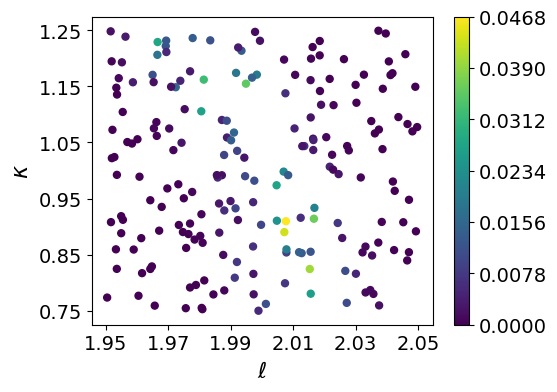

In [54]:
plt.scatter(init_samples[:n_init_samples_small,0], init_samples[:n_init_samples_small,1],
            c=w/n_init_samples_small);

plt.xlabel(r'$\ell$');
plt.ylabel(r'$\kappa$');
plt.xticks(ticks=np.linspace(np.min(XX), np.max(XX), 6),
           labels=["{:.2f}".format(x) for x in np.linspace(np.min(XX), np.max(XX), 6)]);
plt.yticks(ticks=np.linspace(np.min(YY), np.max(YY), 6),
           labels=["{:.2f}".format(x) for x in np.linspace(np.min(YY), np.max(YY), 6)]);

cbar = plt.colorbar();
cbar.set_ticks(np.linspace(np.min(w/n_init_samples_small), np.max(w/n_init_samples_small), 7));
cbar.set_ticklabels(["{:.4f}".format(x) for x in np.linspace(np.min(w/n_init_samples_small),
                                                             np.max(w/n_init_samples_small), 7)]);

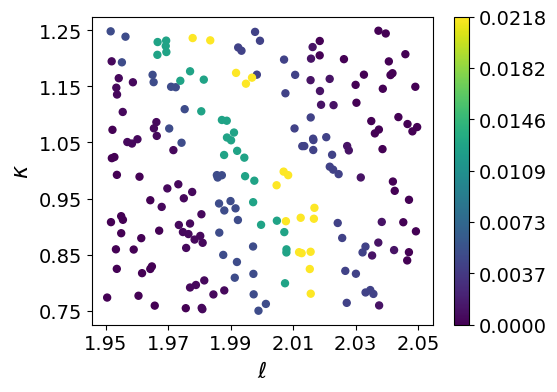

In [55]:
plt.scatter(init_samples[:n_init_samples_small,0], init_samples[:n_init_samples_small,1],
            c=kpartitioned_w);

plt.xlabel(r'$\ell$');
plt.ylabel(r'$\kappa$');
plt.xticks(ticks=np.linspace(np.min(XX), np.max(XX), 6),
           labels=["{:.2f}".format(x) for x in np.linspace(np.min(XX), np.max(XX), 6)]);
plt.yticks(ticks=np.linspace(np.min(YY), np.max(YY), 6),
           labels=["{:.2f}".format(x) for x in np.linspace(np.min(YY), np.max(YY), 6)]);

cbar = plt.colorbar();
cbar.set_ticks(np.linspace(np.min(kpartitioned_w), np.max(kpartitioned_w), 7));
cbar.set_ticklabels(["{:.4f}".format(x) for x in np.linspace(np.min(kpartitioned_w),
                                                             np.max(kpartitioned_w), 7)]);

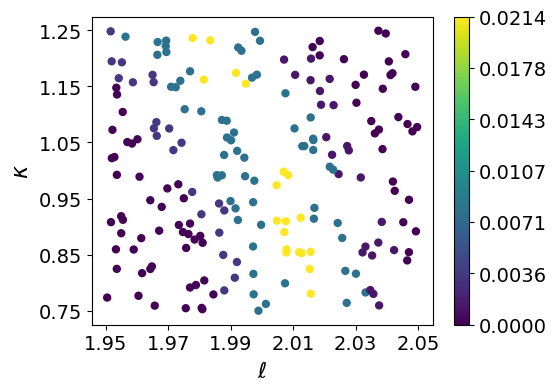

In [56]:
plt.scatter(init_samples[:n_init_samples_small,0], init_samples[:n_init_samples_small,1],
            c=rpartitioned_w);

plt.xlabel(r'$\ell$');
plt.ylabel(r'$\kappa$');
plt.xticks(ticks=np.linspace(np.min(XX), np.max(XX), 6),
           labels=["{:.2f}".format(x) for x in np.linspace(np.min(XX), np.max(XX), 6)]);
plt.yticks(ticks=np.linspace(np.min(YY), np.max(YY), 6),
           labels=["{:.2f}".format(x) for x in np.linspace(np.min(YY), np.max(YY), 6)]);

cbar = plt.colorbar();
cbar.set_ticks(np.linspace(np.min(rpartitioned_w), np.max(rpartitioned_w), 7));
cbar.set_ticklabels(["{:.4f}".format(x) for x in np.linspace(np.min(rpartitioned_w),
                                                             np.max(rpartitioned_w), 7)]);

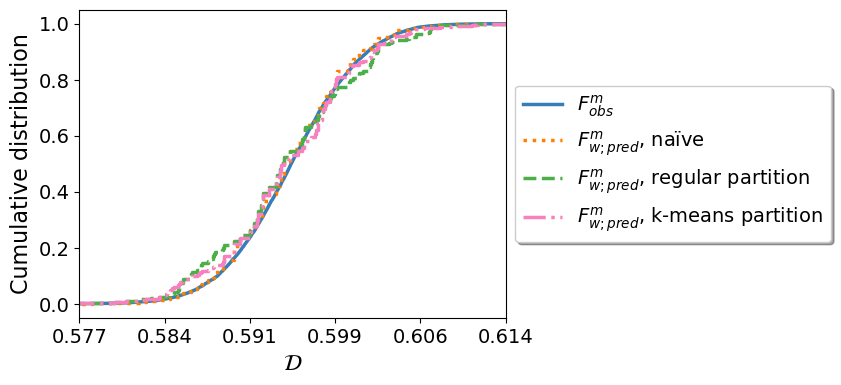

In [58]:
isort = np.argsort(pred_samples[:n_init_samples_small,0])
isort_obs = np.argsort(obs_samples)

plt.plot(np.append(np.min(pred_samples[:,0]), np.append(obs_samples[isort_obs], np.max(pred_samples[:,0]))),
         np.append(0, np.append(np.cumsum([1/n_obs_samples]*n_obs_samples), 1)), label=r'$F^m_{obs}$');
plt.step(pred_samples[isort], np.cumsum(w[isort]/n_init_samples_small),
         label=r'$F^m_{w;pred}$, naïve', ls='dotted');
plt.step(pred_samples[isort], np.cumsum(rpartitioned_w[isort]),
         label=r'$F^m_{w;pred}$, regular partition', ls='--');
plt.step(pred_samples[isort], np.cumsum(kpartitioned_w[isort]),
         label=r'$F^m_{w;pred}$, k-means partition', ls='-.');

plt.xlim(0.584, 0.606)
plt.xticks(ticks=np.linspace(0.584, 0.606, 6),
           labels=["{:.3f}".format(x) for x in np.linspace(np.min(ZZ), np.max(ZZ), 6)]);
plt.xlabel(r'$\mathcal{D}$');
plt.ylabel('Cumulative distribution');
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True);

plt.savefig(f'{plot_directory}/small_cdf_compare.png', bbox_inches='tight');

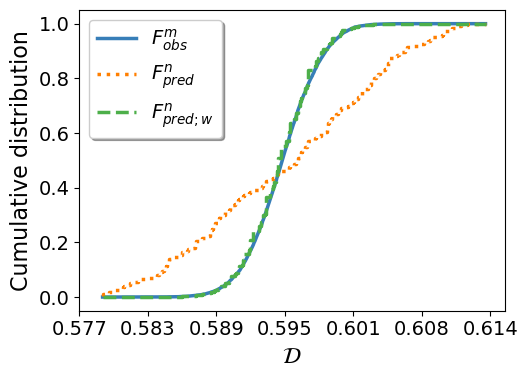

In [59]:
plt.plot(np.append(np.min(pred_samples[:n_init_samples_small,0]),
                   np.append(obs_samples[isort_obs], np.max(pred_samples[:n_init_samples_small,0]))),
         np.append(0, np.append(np.cumsum([1/n_obs_samples]*n_obs_samples), 1)), label='$F^m_{obs}$');

plt.step(pred_samples[isort], np.cumsum([1/n_init_samples_small]*n_init_samples_small),
         label=r'$F^n_{pred}$', ls=':');
plt.step(pred_samples[isort], np.cumsum(w[isort]/n_init_samples_small),
         label=r'$F^n_{pred;w}$', ls='--');

plt.xticks(ticks=np.linspace(np.min(ZZ), np.max(ZZ), 7),
           labels=["{:.3f}".format(x) for x in np.linspace(np.min(ZZ), np.max(ZZ), 7)]);
plt.xlabel(r'$\mathcal{D}$');
plt.ylabel('Cumulative distribution');
plt.legend(loc='upper left', shadow=True);

plt.tight_layout()
plt.savefig(f'{plot_directory}/small_dist_cdfs.png')

In [60]:
r = obs_KDE(pred_samples[:n_init_samples_small].T) / pred_KDE(pred_samples[:n_init_samples_small].T)
rn_w = r / n_init_samples_small
print(f'E(r) = {np.mean(r)}')

E(r) = 0.9375435775865181


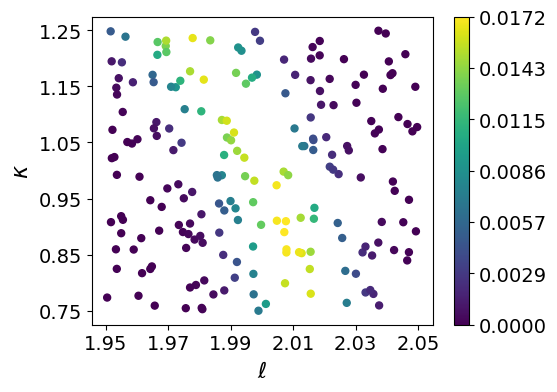

In [61]:
plt.scatter(init_samples[:n_init_samples_small,0], init_samples[:n_init_samples_small,1], c=rn_w);

plt.xlabel(r'$\ell$');
plt.ylabel(r'$\kappa$');
plt.xticks(ticks=np.linspace(np.min(XX), np.max(XX), 6),
           labels=["{:.2f}".format(x) for x in np.linspace(np.min(XX), np.max(XX), 6)]);
plt.yticks(ticks=np.linspace(np.min(YY), np.max(YY), 6),
           labels=["{:.2f}".format(x) for x in np.linspace(np.min(YY), np.max(YY), 6)]);

cbar = plt.colorbar();
cbar.set_ticks(np.linspace(np.min(rn_w), np.max(rn_w), 7));
cbar.set_ticklabels(["{:.4f}".format(x) for x in np.linspace(np.min(rn_w), np.max(rn_w), 7)]);

In [62]:
pf_KDE = GKDE(pred_samples[:n_init_samples_small].T, weights=rn_w)

pred_samples[:n_init_samples_small, 0] = u(N, sensor_loc, t, init_samples[:n_init_samples_small,0],
                                           init_samples[:n_init_samples_small,1])
pred_KDE = GKDE(pred_samples[:n_init_samples_small,0])

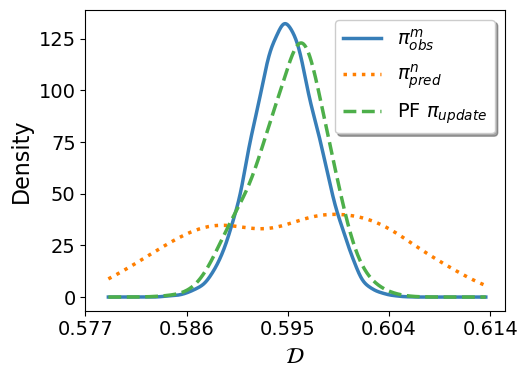

In [63]:
xx = np.linspace(np.min(pred_samples[:n_init_samples_small,0]), np.max(pred_samples[:n_init_samples_small,0]), 1000)

plt.plot(xx, obs_KDE(xx), label=r'$\pi^m_{obs}$');
plt.plot(xx, pred_KDE(xx), label=r'$\pi^n_{pred}$', ls=':');
plt.plot(xx, pf_KDE(xx), label=r'PF $\pi_{update}$', ls='dashed');

plt.xticks(ticks=np.linspace(np.min(ZZ), np.max(ZZ), 5),
           labels=["{:.3f}".format(x) for x in np.linspace(np.min(ZZ), np.max(ZZ), 5)]);
plt.xlabel(r'$\mathcal{D}$');
plt.ylabel('Density');
plt.legend(loc='upper right', shadow=True);

plt.tight_layout();
plt.savefig(f'{plot_directory}/small_dens_results.png');

## No density example

This next example corresponds to the no density admitting case, which is at at the end of section 3.4 in the paper and shown in Figure 10.

In [64]:
data_space = [0.585, 0.6]

n_data_pieces = 3
data_splits = (np.array([0, 1/3, 2/3, 1]) * (data_space[1] - data_space[0])) + 0.585

print(data_splits)

[0.585 0.59  0.595 0.6  ]


In [65]:
obs_dens_pieces = [5, 1, 4]
obs_dens_pieces = obs_dens_pieces / np.sum(obs_dens_pieces)
obs_dens_pieces = [obs_dens_pieces[i] / (data_splits[i+1] - data_splits[i]) for i in range(n_data_pieces)]

print(obs_dens_pieces)
print(np.array(obs_dens_pieces) * (data_splits[1] - data_splits[0]))

[99.99999999999991, 19.999999999999982, 79.99999999999993]
[0.5 0.1 0.4]


In [66]:
def obs_dens(x):
    dens = np.zeros(len(x))
    for i in range(0, n_data_pieces-1):
        dens[(x >= data_splits[i]) & (x < data_splits[i+1])] = obs_dens_pieces[i]
    dens[(x >= data_splits[-2]) & (x <= data_splits[-1])] = obs_dens_pieces[-1]
    return dens

In [67]:
def obs_cdf(x):
    dist = np.zeros(len(x))
    for i in range(1, n_data_pieces):
        dist[(x > data_splits[i])] += obs_dens_pieces[i-1] * (data_splits[i+1] - data_splits[i])
    for i in range(0, n_data_pieces-1):
        tot = obs_dens_pieces[i] * (data_splits[i+1] - data_splits[i])
        frac = (x[(x >= data_splits[i]) & (x < data_splits[i+1])] - data_splits[i]) / (data_splits[i+1] - data_splits[i])
        dist[(x >= data_splits[i]) & (x < data_splits[i+1])] += frac * tot
    tot = obs_dens_pieces[-1] * (data_splits[-1] - data_splits[-2])
    frac = (x[(x >= data_splits[-2]) & (x <= data_splits[-1])] - data_splits[-2]) / (data_splits[-1] - data_splits[-2])
    dist[(x >= data_splits[-2]) & (x <= data_splits[-1])] += frac * tot
    return dist

In [68]:
def obs_sample(n):
    where = np.random.uniform(0, 1, n)
    samples = np.zeros(np.shape(where))
    ocm = np.append(0, np.cumsum([obs_dens_pieces[i] * (data_splits[i+1] - data_splits[i]) for i in range(n_data_pieces)]))
    for i in range(0, n_data_pieces):
        samples[(where >= ocm[i]) & (where < ocm[i+1])] = np.random.uniform(data_splits[i], data_splits[i+1], np.sum([(where >= ocm[i]) & (where < ocm[i+1])]))
    return samples

In [69]:
n_obs_samples = 10000
obs_samples = obs_sample(n_obs_samples)

obs_KDE = GKDE(obs_samples)

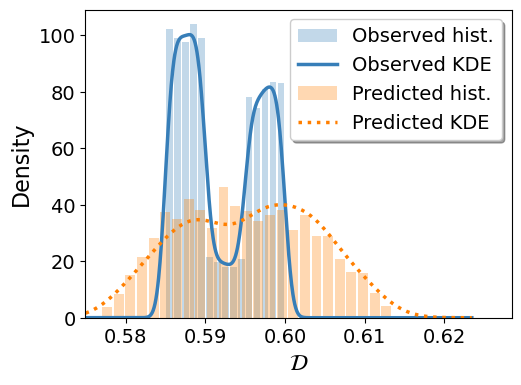

In [70]:
xx = np.linspace(np.min(pred_samples)-0.01, np.max(pred_samples)+0.01, 1000)

plt.hist(obs_samples, bins=15, alpha=0.3, density=True, label='Observed hist.', rwidth=0.85, color=CB_color_cycle[0]);
plt.plot(xx, obs_KDE(xx), color=CB_color_cycle[0], label='Observed KDE');

plt.hist(pred_samples, bins=25, alpha=0.3, density=True, label='Predicted hist.', rwidth=0.85, color=CB_color_cycle[1]);
plt.plot(xx, pred_KDE(xx), color=CB_color_cycle[1], label='Predicted KDE', ls=':');

plt.legend(shadow=True);
plt.xlabel(r'$\mathcal{D}$');
plt.xlim(np.min(pred_samples[:,0]-0.002), np.max(pred_samples[:,0]+0.015));
plt.ylabel('Density');

plt.savefig(f'{plot_directory}/no_density_dists.png', bbox_inches='tight');

In [71]:
r_no_dens = obs_KDE(pred_samples.T) / pred_KDE(pred_samples.T)
print(f'E(r) = {np.mean(r_no_dens)}')

update_inds = rejection_sampling(r_no_dens)
update_samples = init_samples[update_inds]

pf_samples = pred_samples[update_inds]
pf_KDE = GKDE(pf_samples.T)

E(r) = 1.083313191231814


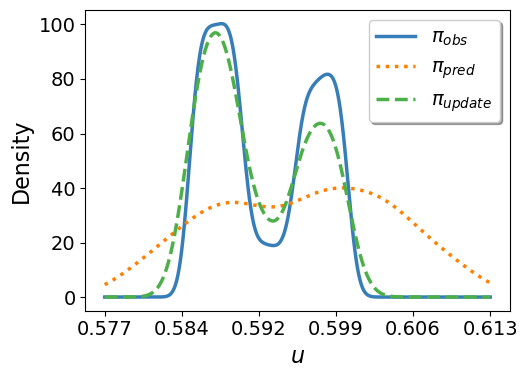

In [72]:
xx = np.linspace(np.min(pred_samples[:,0]), np.max(pred_samples[:,0]), 1000)

plt.plot(xx, obs_KDE(xx), label=r'$\pi_{obs}$');
plt.plot(xx, pred_KDE(xx), label=r'$\pi_{pred}$', ls=':');
plt.plot(xx, pf_KDE(xx), label=r'$\pi_{update}$', ls='--');

plt.xticks(ticks=np.linspace(np.min(pred_samples), np.max(pred_samples), 6),
           labels=["{:.3f}".format(x) for x in np.linspace(np.min(pred_samples), np.max(pred_samples), 6)]);
plt.xlabel(r'$u$');
plt.ylabel('Density');
plt.legend(shadow=True);

plt.tight_layout();
plt.savefig(f'{plot_directory}/no_dens_density.png', bbox_inches='tight');

In [73]:
n_bins=100
kpartitioned_w, clusters, centers, w_center = binning.computePartitionedWeights_kMeans_IID(init_samples,
                                                        pred_samples,
                                                        sample_set_2=np.reshape(obs_samples, (len(obs_samples),1)),
                                                        n_clusters=n_bins)

     pcost       dcost       gap    pres   dres
 0: -2.4288e-01 -1.0028e+02  1e+02  3e-16  2e+01
 1: -2.4290e-01 -1.2844e+00  1e+00  2e-15  2e-01
 2: -2.4498e-01 -2.8982e-01  4e-02  2e-15  9e-03
 3: -2.5329e-01 -2.6191e-01  9e-03  2e-15  1e-17
 4: -2.5516e-01 -2.5736e-01  2e-03  2e-15  2e-17
 5: -2.5553e-01 -2.5593e-01  4e-04  3e-15  2e-17
 6: -2.5562e-01 -2.5569e-01  6e-05  3e-15  1e-17
 7: -2.5564e-01 -2.5565e-01  1e-05  3e-15  2e-17
 8: -2.5564e-01 -2.5564e-01  2e-06  3e-15  1e-17
 9: -2.5564e-01 -2.5564e-01  2e-07  3e-15  1e-17
Optimal solution found.


In [74]:
pf_CDF = np.zeros(np.shape(xx[1:]))
for count, x in enumerate(xx[1:]):
    pf_CDF[count],temp = integrate.quad(pf_KDE, np.min(pred_samples[:,0]), x)

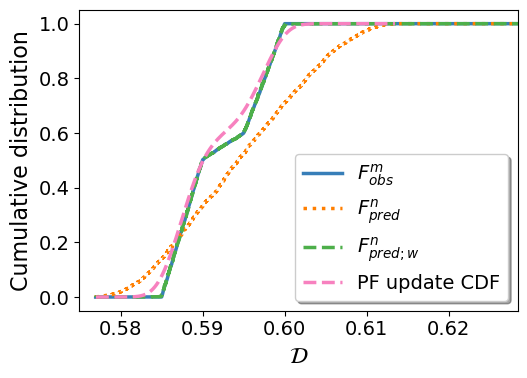

In [75]:
isort = np.argsort(pred_samples[:,0])
isort_obs = np.argsort(obs_samples)

plt.step(np.append(np.min(pred_samples[:,0]), np.append(obs_samples[isort_obs], np.max(pred_samples[:,0])+0.015)),
         np.append(0, np.append(np.cumsum([1/n_obs_samples]*n_obs_samples), 1)),
         label=r'$F^m_{obs}$');
plt.step(np.append(pred_samples[isort,0], np.max(pred_samples[:,0])+0.015),
         np.append(np.cumsum([1/n_init_samples]*n_init_samples), 1), label='$F^n_{pred}$', ls=':');
plt.step(np.append(pred_samples[isort,0], np.max(pred_samples[:,0])+0.015),
         np.append(np.cumsum(kpartitioned_w[isort]), 1), label='$F^n_{pred;w}$', ls='--');
plt.plot(xx[1:], pf_CDF, label='PF update CDF', ls='--');

plt.xlabel(r'$\mathcal{D}$');
plt.xlim(np.min(pred_samples[:,0]-0.002), np.max(pred_samples[:,0]+0.015));
plt.ylabel('Cumulative distribution');
plt.legend(loc='lower right', shadow=True);

plt.tight_layout();
plt.savefig(f'{plot_directory}/no_dens_cdfs.png', bbox_inches='tight');

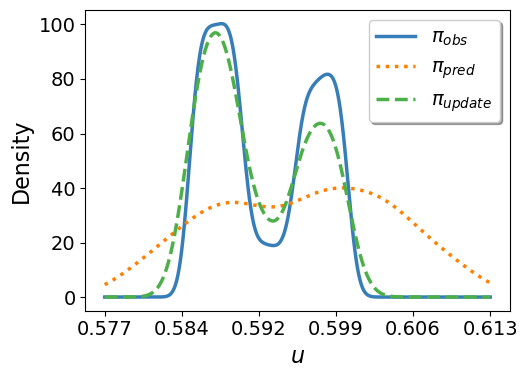

In [76]:
xx = np.linspace(np.min(pred_samples[:,0]), np.max(pred_samples[:,0]), 1000)

plt.plot(xx, obs_KDE(xx), label=r'$\pi_{obs}$');
plt.plot(xx, pred_KDE(xx), label=r'$\pi_{pred}$', ls=':');
plt.plot(xx, pf_KDE(xx), label=r'$\pi_{update}$', ls='--');

plt.xticks(ticks=np.linspace(np.min(pred_samples), np.max(pred_samples), 6),
           labels=["{:.3f}".format(x) for x in np.linspace(np.min(pred_samples), np.max(pred_samples), 6)]);
plt.xlabel(r'$u$');
plt.ylabel('Density');
plt.legend(shadow=True);

plt.tight_layout();
plt.savefig(f'{plot_directory}/no_dens_densities.png', bbox_inches='tight');